<a href="https://colab.research.google.com/github/dmao1020/bigqhack_QAI_2022/blob/main/QAOA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#pip install pulser

In [96]:
#pip install igraph

In [191]:
import numpy as np
import igraph
from itertools import combinations

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.devices import Chadoq2

from scipy.optimize import minimize

In [237]:
def pos_to_graph(pos):
    rb = Chadoq2.rydberg_blockade_radius(1.0)
    g = igraph.Graph()
    N = len(pos)
    edges = [
        [m, n]
        for m, n in combinations(range(N), r=2)
        if np.linalg.norm(pos[m] - pos[n]) < rb
    ]
    g.add_vertices(N)
    g.add_edges(edges)
    return g

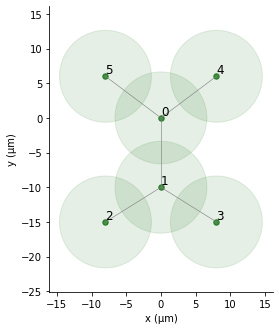

In [244]:
pos =np.array([[0.0, 0.0], 
               [0.0, -10.0],
               [-8, -15], 
               [8, -15], 
               [8, 6], 
               [-8, 6]])
#([[0,1],[0,2],[0,3],[1,4],[1,5]])
#np.array([[0.0, 0.0], [-4, -7], [4, -7], [8, 6], [-8, 6]])

G = pos_to_graph(pos)
qubits = dict(enumerate(pos))

reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [245]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

if LAYERS == 1:
    t_list = [t_list]
    s_list = [s_list]

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 1.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [247]:
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [248]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])



In [249]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # MIS indexes
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

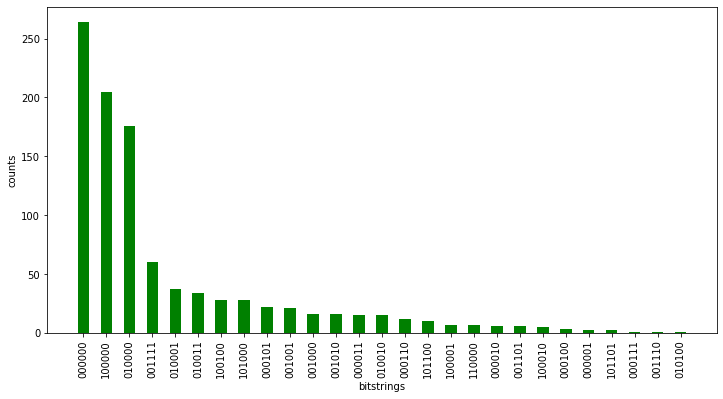

In [250]:
plot_distribution(example_dict)


In [251]:
def get_cost_colouring(bitstring, G, penalty=10):
    z = np.array(list(bitstring), dtype=int)
    A = np.array(G.get_adjacency().data)
    # Add penalty and bias:
    cost = penalty * (z.T @ np.triu(A) @ z) - np.sum(z)
    return cost


def get_cost(counter, G):
    cost = sum(counter[key] * get_cost_colouring(key, G) for key in counter)
    return cost / sum(counter.values())  # Divi

In [252]:
get_cost_colouring("110000", G)


8

In [253]:
get_cost(example_dict, G)

-1.02

In [254]:
def func(param, *args):
    G = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, G)
    return cost

In [255]:
res = minimize(
    func,
    args=G,
    x0=np.r_[guess["t"], guess["s"]],
    method="Nelder-Mead",
    tol=1e-5,
    options={"maxiter": 100},
)

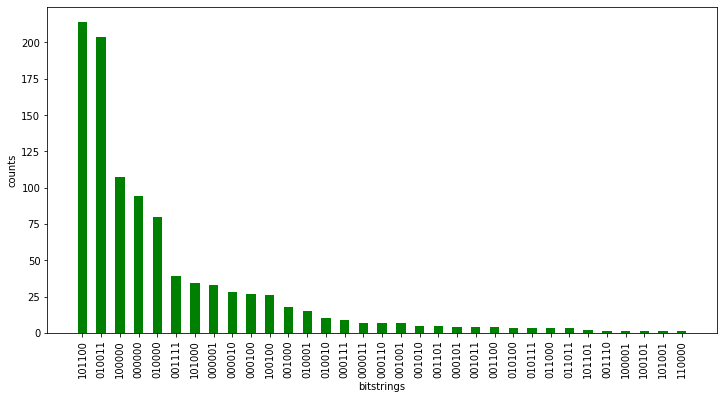

In [256]:
count_dict = quantum_loop(res.x)
plot_distribution(count_dict)

In [270]:
import operator

print ("count_dict:",count_dict)
sorted_x = sorted(count_dict.items(), key=operator.itemgetter(1))
print (sorted_x)

count_dict: Counter({'101100': 214, '010011': 204, '100000': 107, '000000': 94, '010000': 80, '001111': 39, '101000': 34, '000001': 33, '000010': 28, '000100': 27, '100100': 26, '001000': 18, '010001': 15, '010010': 10, '000111': 9, '000011': 7, '000110': 7, '001001': 7, '001010': 5, '001101': 5, '000101': 4, '001011': 4, '001100': 4, '010100': 3, '010111': 3, '011000': 3, '011011': 3, '101101': 2, '001110': 1, '100001': 1, '100101': 1, '101001': 1, '110000': 1})
[('001110', 1), ('100001', 1), ('100101', 1), ('101001', 1), ('110000', 1), ('101101', 2), ('010100', 3), ('010111', 3), ('011000', 3), ('011011', 3), ('000101', 4), ('001011', 4), ('001100', 4), ('001010', 5), ('001101', 5), ('000011', 7), ('000110', 7), ('001001', 7), ('000111', 9), ('010010', 10), ('010001', 15), ('001000', 18), ('100100', 26), ('000100', 27), ('000010', 28), ('000001', 33), ('101000', 34), ('001111', 39), ('010000', 80), ('000000', 94), ('100000', 107), ('010011', 204), ('101100', 214)]


In [276]:
opt_1 = sorted_x[0][0]
A = np.array(G.get_adjacency().data)
n,d = np.shape(A)
for i in range(d):
  row_i = A[i,:]
  print (i,row_i)
  if 




0 [0 1 0 0 1 1]
1 [1 0 1 1 0 0]
2 [0 1 0 0 0 0]
3 [0 1 0 0 0 0]
4 [1 0 0 0 0 0]
5 [1 0 0 0 0 0]
